In [1]:
import pytorch_lightning as pl
import torch 
from pytorch_lightning.metrics.functional.classification import accuracy
from tqdm import tqdm
from src import DataModule, TIMM
import torchvision
import pandas as pd 
from pathlib import Path
from skimage import io
import glob
import cv2
import timm

torch.__version__, timm.__version__

('1.7.0', '0.3.2')

In [2]:
models = glob.glob('efficientnet*.ckpt')
models

['efficientnet_b3-256-val_acc=0.83750.ckpt',
 'efficientnet-b5-256-val_acc=0.81250.ckpt',
 'efficientnet_b3-256-val_acc=0.85899.ckpt',
 'efficientnet-b0-256-val_acc=0.69766.ckpt']

In [3]:
model = TIMM.load_from_checkpoint(checkpoint_path='efficientnet_b3-256-val_acc=0.85899.ckpt')
model.hparams

"backbone":      efficientnet_b3
"batch_size":    128
"es_start_from": 0
"extra_data":    1
"lr":            0.0003
"max_epochs":    50
"num_workers":   20
"optimizer":     Adam
"patience":      3
"precision":     16
"size":          256
"subset":        0.0
"train_trans":   {'RandomCrop': {'height': 256, 'width': 256}, 'HorizontalFlip': {}, 'VerticalFlip': {}, 'Normalize': {}}
"val_batches":   1.0
"val_trans":     {'CenterCrop': {'height': 256, 'width': 256}, 'Normalize': {}}

In [4]:
class FinalModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.trans = torch.nn.Sequential(
            torchvision.transforms.CenterCrop(256),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        )
        self.trans_tta = torch.nn.Sequential(
            torchvision.transforms.RandomCrop(256),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        )
    
    def forward(self, x, tta : int = 0):
        x = x.float() / 255.
        x = x.permute(2, 0, 1)
        if tta == 0:
            imgs = self.trans(x).unsqueeze(0)
            y_hat = self.model(imgs)[0]
        else:
            imgs = torch.stack([self.trans_tta(x) for i in range(tta)])
            y_hat = self.model(imgs).mean(dim=0)
        return torch.softmax(y_hat, dim=0)

In [5]:
final_model = FinalModel(model.m.cpu())

In [6]:
path = Path('data')
images_path = Path('extra/test/0')
images = os.listdir(path/images_path)
images_paths = [str(images_path/img) for img in images]
len(images)

3774

In [7]:
def predict(model, imgs, tta=0, t = 0.95):   
    model.eval()
    model.cuda()
    preds, images = [], []
    with torch.no_grad():
        for img_name in tqdm(imgs):
            img = cv2.imread(str(path/img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = torch.from_numpy(img).cuda()
            y_hat = model(img, tta).cpu()
            max_ix = torch.argmax(y_hat)
            if y_hat[max_ix] >= t:
                preds.append(max_ix.item())
                images.append(img_name)

    return preds, images

In [8]:
preds, images = predict(final_model, images_paths)
len(preds)

100%|██████████| 3774/3774 [01:52<00:00, 33.45it/s]


2255

In [9]:
new_dataset = pd.DataFrame({'image_id': images, 'label': preds })
new_dataset

,image_id,label
0,extra/test/0/test-img-1292.jpg,1
1,extra/test/0/test-img-809.jpg,1
2,extra/test/0/test-img-2149.jpg,1
3,extra/test/0/test-img-406.jpg,1
4,extra/test/0/test-img-94.jpg,3
...,...,...
2250,extra/test/0/test-img-421.jpg,2
2251,extra/test/0/test-img-25.jpg,3
2252,extra/test/0/test-img-1553.jpg,3
2253,extra/test/0/test-img-219.jpg,2


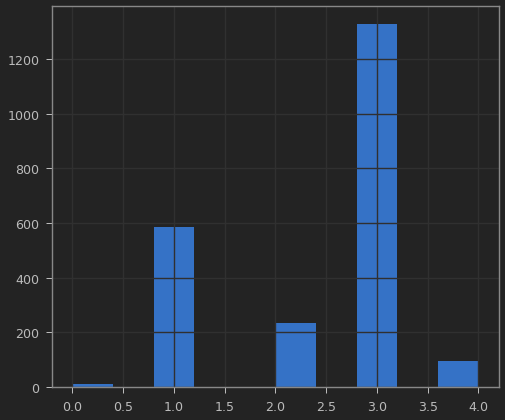

In [10]:
new_dataset.label.hist()
plt.show()

In [11]:
path = Path('data')
images_path = Path('extra/extraimages')
extra_images = os.listdir(path/images_path)
images_paths = [str(images_path/img) for img in extra_images]
len(extra_images)

12596

In [12]:
extra_preds, extra_images = predict(final_model, images_paths)
len(extra_preds)

100%|██████████| 12596/12596 [06:12<00:00, 33.82it/s]


6756

In [13]:
new_dataset = pd.DataFrame({'image_id': images + extra_images, 'label': preds + extra_preds})
new_dataset

,image_id,label
0,extra/test/0/test-img-1292.jpg,1
1,extra/test/0/test-img-809.jpg,1
2,extra/test/0/test-img-2149.jpg,1
3,extra/test/0/test-img-406.jpg,1
4,extra/test/0/test-img-94.jpg,3
...,...,...
9006,extra/extraimages/extra-image-1815.jpg,3
9007,extra/extraimages/extra-image-3148.jpg,3
9008,extra/extraimages/extra-image-2484.jpg,1
9009,extra/extraimages/extra-image-9895.jpg,3


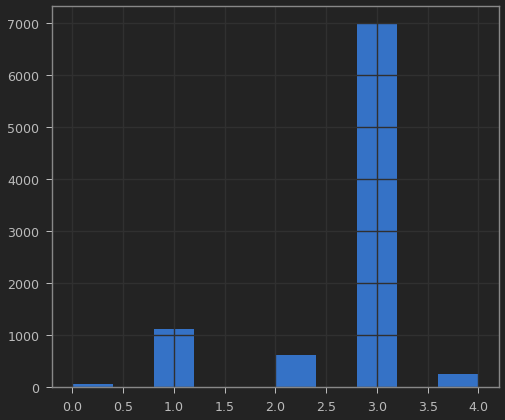

In [20]:
new_dataset.label.hist()
plt.show()

In [21]:
old_dataset = pd.read_csv('data/train_extra.csv')
old_dataset

,image_id,label
0,train_images/1000015157.jpg,0
1,train_images/1000201771.jpg,3
2,train_images/100042118.jpg,1
3,train_images/1000723321.jpg,1
4,train_images/1000812911.jpg,3
...,...,...
27048,extra/train/healthy/train-healthy-22.jpg,4
27049,extra/train/healthy/train-healthy-228.jpg,4
27050,extra/train/healthy/train-healthy-205.jpg,4
27051,extra/train/healthy/train-healthy-94.jpg,4


In [22]:
extra_dataset = pd.concat([new_dataset, old_dataset])
extra_dataset

,image_id,label
0,extra/test/0/test-img-1292.jpg,1
1,extra/test/0/test-img-809.jpg,1
2,extra/test/0/test-img-2149.jpg,1
3,extra/test/0/test-img-406.jpg,1
4,extra/test/0/test-img-94.jpg,3
...,...,...
27048,extra/train/healthy/train-healthy-22.jpg,4
27049,extra/train/healthy/train-healthy-228.jpg,4
27050,extra/train/healthy/train-healthy-205.jpg,4
27051,extra/train/healthy/train-healthy-94.jpg,4


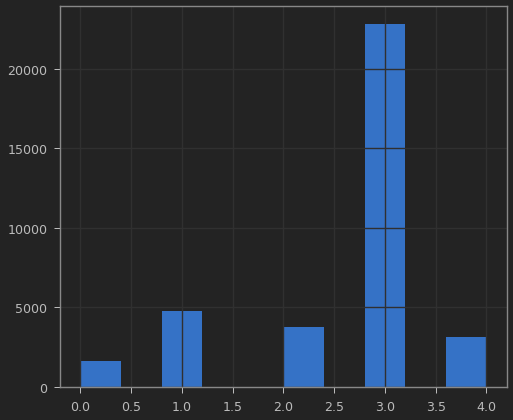

In [23]:
extra_dataset.label.hist()
plt.show()

In [24]:
extra_dataset.to_csv(path/'train_pseudo.csv', index=False)

In [25]:
from sklearn.model_selection import train_test_split

def data_split(df, test_size=0.2, random_state=42):
    train, val = train_test_split(
        df,
        test_size=test_size,
        shuffle=True,
        stratify=df['label'],
        random_state=random_state
    )
    return train, val    

In [26]:
train, val = data_split(extra_dataset)

len(train), len(val)

(28851, 7213)

In [27]:
train.to_csv(path/'data_pseudo_train.csv', index=False)
val.to_csv(path/'data_pseudo_val.csv', index=False)